In [8]:
# TODO: Move some of the functions in this notebook into package
category = 'gluten_free_flour'

In [17]:
import re

import pandas as pd
import matplotlib.pyplot as plt

from product_meta_analysis.database.database import Database


DEFAULT_COLORS = ['#0472c2', '#1ec5d6', '#fcd251', '#c36c6c', '#eac1c1', '#c5c5c5']

font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)


### Get data

In [49]:
# TODO: add a read_pandas function to Database class
db = Database()
comments = db.read(f"""
    select 
        c.comment_id,
        c.upvotes,
        c.parent_id, 
        a.sentence_ix, 
        a.brand,
        a.annotation_id
    from reddit_comments c 
    inner join reddit_comment_annotations a
        on a.comment_id = c.comment_id
    where c.category='{category}'
    """)
comments = pd.DataFrame(comments, columns=['comment_id', 'upvotes', 'parent_id', 'sentence_ix', 'brand', 'annotation_id'])
db.close() 

# NOTE: t3_threadid are top level comments and t1_commentid are lower level comments
comments['is_top_level'] = comments['parent_id'].map(lambda x: 1 if re.match('t3_', x) else 0)
comments['parent_id_trucated'] = comments['parent_id'].map(lambda x: x[3:])
brand_counts = comments \
    .groupby('comment_id') \
    .apply(lambda x: len(set(x['brand']))) \
    .reset_index()\
    .rename(columns={0:'brand_count'})
comments = comments.merge(brand_counts, on='comment_id', how='left') 
elligible_comments = comments[
        (comments['is_top_level'] == 1) &
        (comments['brand_count'] <= 2)
        ] \
    .drop_duplicates(subset=['comment_id', 'brand'])
    
elligible_comments.head(5)

,comment_id,upvotes,parent_id,sentence_ix,brand,annotation_id,is_top_level,parent_id_trucated,brand_count
0,dx89ctf,8,t3_8bnn0y,0,Bob's Red Mill,dx89ctf02,1,8bnn0y,1
1,dx8ku69,7,t3_8bnn0y,0,Cup4cup,dx8ku6901,1,8bnn0y,1
2,dx8a8g5,5,t3_8bnn0y,0,King Arthur,dx8a8g500,1,8bnn0y,2
3,dx8a8g5,5,t3_8bnn0y,1,Bob's Red Mill,dx8a8g512,1,8bnn0y,2
4,dx8ex8y,5,t3_8bnn0y,3,King Arthur,dx8ex8y30,1,8bnn0y,1


In [60]:
df = elligible_comments \
    .groupby(['parent_id_trucated', 'brand']) \
    .agg({'upvotes': 'sum'}) \
    .reset_index() \
    .rename(columns={
            'parent_id_trucated': 'Thread',
            'brand': 'Brand',
            'upvotes': 'Votes'
        })
    
df.head(5)

,Thread,Brand,Votes
0,1rz9xu,Bob's Red Mill,1
1,1rz9xu,Cup4cup,3
2,1rz9xu,King Arthur,1
3,2fr0vn,Bob's Red Mill,8
4,2fr0vn,Cup4cup,12


### Summary stats

In [54]:
def print_summary_stats(df): 
    threads = df['Thread'].nunique()
    upvotes = df['Votes'].sum()
    comments = df['Votes'].count()
    brands = df['Brand'].nunique()

    print(f"Number of threads: {threads}")
    print(f"Number of comments: {comments}")
    print(f"Number of upvotes: {upvotes}")
    print(f"Number of threads: {brands}")
    
print_summary_stats(df)

Number of threads: 9
Number of comments: 25
Number of upvotes: 166
Number of threads: 3


### Vote summary

In [55]:
def get_vote_summary(df, group_ = 'Brand', agg_ = ['sum', 'count', 'mean']): 
    group_ = 'Brand'
    vote_summary = df \
        .groupby(group_) \
        .agg({'Votes': agg_}) \
        .sort_values(('Votes','sum'), ascending=False) \
        .reset_index()
    vote_summary.columns = [group_] + agg_ 

    return vote_summary

votes = get_vote_summary(df)
votes

,Brand,sum,count,mean
0,Bob's Red Mill,77,9,8.555556
1,King Arthur,46,7,6.571429
2,Cup4cup,43,9,4.777778


### Total votes

In [56]:
votes_clean = votes.copy() \
    .rename(columns={
            "sum": "Total Votes", 
            "count":"Total Comments",
            "mean":"Average Votes per Comment"
        }) \
    .round(1)
    
votes_clean

,Brand,Total Votes,Total Comments,Average Votes per Comment
0,Bob's Red Mill,77,9,8.6
1,King Arthur,46,7,6.6
2,Cup4cup,43,9,4.8


### Plots

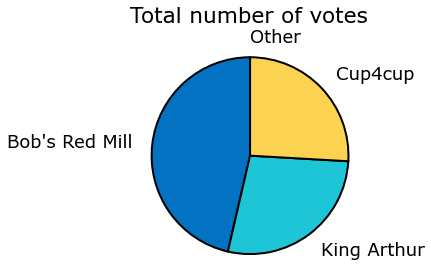

In [57]:
def add_chart_title(column): 
    if column == 'sum':
        return plt.title('Total number of votes', pad=25)
    elif column == 'count':
        return plt.title('Total number of comments', pad=25)

def bin_long_tail(df, count_threshold, column): 
    df_ = df.copy()
    above_threshold = df_[df_['count'] >= count_threshold]
    below_threshold = df_[df_['count'] < count_threshold]
    binned = pd.concat([
            above_threshold[['Brand', column]],
            pd.DataFrame(
                [['Other', int(below_threshold[column].sum())]],
                columns=['Brand', column]
                )
        ])
    return binned

def create_pie_chart(df, count_threshold = 3, column='sum'):
    votes_binned = bin_long_tail(df, count_threshold, column)
    n = len(votes_binned)

    fig, ax = plt.subplots()
    ax.pie(
        votes_binned[column], 
        labels=votes_binned['Brand'], 
        colors=DEFAULT_COLORS[0:n], 
        startangle=90,
        labeldistance=1.2,
        pctdistance=0.7,
        wedgeprops = {"edgecolor":"k",'linewidth': 2, 'linestyle': 'solid', 'antialiased': True}
        )
    ax.axis('equal')  
    add_chart_title(column)
        
    plt.show()

create_pie_chart(votes)

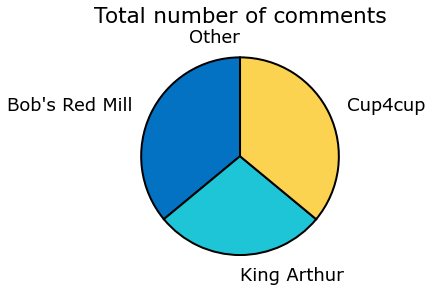

In [58]:
create_pie_chart(votes, column='count')

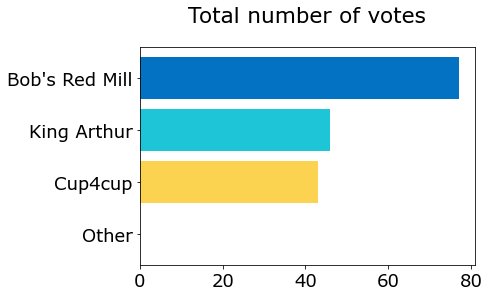

In [59]:
def create_bar_chart(df, count_threshold = 3, column='sum'):
    votes_binned = bin_long_tail(df, count_threshold, column)
    n = len(votes_binned)

    fig, ax = plt.subplots()
    ax.barh(
        votes_binned['Brand'],
        votes_binned[column],  
        color=DEFAULT_COLORS[0:n], 
        )
    ax.invert_yaxis()
    add_chart_title(column)

        
    plt.show()

create_bar_chart(votes)